In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import ticker
import matplotlib.patches as patches

## Compute Responsiveness Data

In [14]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
modes_dir = os.path.join(projectPath, 'sumoenv/scenarios/normal')

records = []
# Traverse each mode (sumo, social_groups, multi_agent)
for mode in os.listdir(modes_dir):
    mode_path = os.path.join(modes_dir, mode)
    if not os.path.isdir(mode_path):
        continue
    # Traverse each folder inside the mode
    for date in os.listdir(mode_path):
        date_path = os.path.join(mode_path, date)
        if not os.path.isdir(date_path):
            continue
        summary_path = os.path.join(date_path, 'simulation_summary.csv')
        if os.path.exists(summary_path):
            df_summary = pd.read_csv(summary_path)
            if not df_summary.empty:
                first_row = df_summary.iloc[0]
                elapsed_sec = first_row['total_elapsed_seconds']
                sumo_sec = first_row['sumo_time']
                try:
                    agents_sec = first_row['agents_time']
                except KeyError:
                    agents_sec = 0
                metrics_path = os.path.join(date_path, 'sf_final_metrics.csv')
                if os.path.exists(metrics_path):
                    df_metrics = pd.read_csv(metrics_path)
                    if not df_metrics.empty:
                        traffic_count = sum(df_metrics['traffic_departures'])
                        pickup_count = sum(df_metrics['passengers_departures'])
                        dropoff_count = sum(df_metrics['passengers_arrivals'])
                        canceled_count = sum(df_metrics['passengers_cancel']) + sum(df_metrics['rides_not_served'])
                        total_load = traffic_count + pickup_count + dropoff_count + canceled_count
                        records.append({
                            'mode': mode,
                            'date': date,
                            'elapsed_seconds': elapsed_sec,
                            'elapsed_minutes': round(elapsed_sec / 60, 2),
                            'sumo_time': sumo_sec,
                            'sumo_minutes': round(sumo_sec / 60, 2),
                            'agents_time': agents_sec,
                            'agents_minutes': round(agents_sec / 60, 2),
                            'sumo_perc_time': round(sumo_sec / elapsed_sec, 2),
                            'agents_perc_time': round(agents_sec / elapsed_sec, 2) if agents_sec > 0 else 0,
                            'total_load': total_load
                        })
                        
# Save results to CSV
summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv')
summary_df = summary_df.sort_values(by=['mode', 'date'])
summary_df.to_csv(output_file, index=False)

print(f"Responsiveness summary saved to: {output_file}")

Responsiveness summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/responsiveness_normal.csv


## Compute Avg across Modes

In [15]:
df = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'))
# Columns to average
avg_cols = ['elapsed_seconds', 'elapsed_minutes', 'sumo_time', 'sumo_minutes', 'agents_time', 'agents_minutes', 'sumo_perc_time', 'agents_perc_time', 'total_load']
multi_agent_modes = ['multi_agent_1', 'multi_agent_2']
social_group_modes = ['social_groups_1', 'social_groups_2', 'social_groups_3']
# Compute averages per date_key for each group
multi_avg = (
    df[df['mode'].isin(multi_agent_modes)]
    .groupby('date')[avg_cols]
    .mean()
    .round(2)
    .reset_index()
)
multi_avg['mode'] = 'multi_agent_avg'
social_avg = (
    df[df['mode'].isin(social_group_modes)]
    .groupby('date')[avg_cols]
    .mean()
    .round(2)
    .reset_index()
)
social_avg['mode'] = 'social_groups_avg'

# Reorder columns
multi_avg = multi_avg[['mode', 'date', *avg_cols]]
social_avg = social_avg[['mode', 'date', *avg_cols]]

# Append to original dataframe and save
df_result = pd.concat([df, multi_avg, social_avg], ignore_index=True)
df_result.to_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'), index=False)

## Plot Responsiveness Data

In [16]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
df_results = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'))
df_results = df_results[df_results['mode'].isin(['sumo', 'social_groups_avg', 'multi_agent_avg'])]

# Extract start, end and duration hour from the 'date' column
df_results['start_hour'] = df_results['date'].str.extract(r'^(\d{6})(\d{2})_')[1].astype(int)
df_results['end_hour'] = df_results['date'].str.extract(r'_(\d{6})(\d{2})$')[1].astype(int)
df_results['duration_h'] = df_results['end_hour'] - df_results['start_hour']
df_results['duration_h'] = (df_results['end_hour'] - df_results['start_hour']) % 24

# Add day/night label based on starting hour
df_results['time_of_day'] = df_results['start_hour'].apply(lambda h: 'day' if h == 8 else 'night')

# Columns to average
value_columns = [
    'elapsed_seconds', 'elapsed_minutes', 'sumo_time', 'sumo_minutes',
    'agents_time', 'agents_minutes', 'sumo_perc_time', 'agents_perc_time'
]

# Assign averages to separate variables
time_sumo_1h_avg_d = df_results[(df_results['mode'] == 'sumo') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sumo_3h_avg_d = df_results[(df_results['mode'] == 'sumo') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sumo_1h_avg_n = df_results[(df_results['mode'] == 'sumo') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_sumo_3h_avg_n = df_results[(df_results['mode'] == 'sumo') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_ma_1h_avg_d = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_ma_3h_avg_d = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()/3
time_ma_6h_avg_d = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 6) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()/6
time_ma_12h_avg_d = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 12) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()/12
time_ma_1h_avg_n = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_ma_3h_avg_n = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()/3
time_ma_6h_avg_n = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 6) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()/6
time_ma_12h_avg_n = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 12) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()/12
time_sg_1h_avg_d = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sg_3h_avg_d = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()/3
time_sg_6h_avg_d = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 6) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()/6
time_sg_12h_avg_d = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 12) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()/12
time_sg_1h_avg_n = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_sg_3h_avg_n = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()/3
time_sg_6h_avg_n = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 6) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()/6
time_sg_12h_avg_n = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 12) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()/12

In [17]:
sumo_avg_d = [time_sumo_1h_avg_d, time_sumo_3h_avg_d, np.nan, np.nan]
ma_avg_d = [time_ma_1h_avg_d, time_ma_3h_avg_d, time_ma_6h_avg_d, time_ma_12h_avg_d]
sg_avg_d = [time_sg_1h_avg_d, time_sg_3h_avg_d, time_sg_6h_avg_d, time_sg_12h_avg_d]
sumo_avg_n = [time_sumo_1h_avg_n, time_sumo_3h_avg_n, np.nan, np.nan]
ma_avg_n = [time_ma_1h_avg_n, time_ma_3h_avg_n, time_ma_6h_avg_n, time_ma_12h_avg_n]
sg_avg_n = [time_sg_1h_avg_n, time_sg_3h_avg_n, time_sg_6h_avg_n, time_sg_12h_avg_n]
# Estimate SUMO day and night for 6 and 12 hours using power law fitting
x_hours_known = np.array([1, 3])
y_sumo_day_known = np.array([time_sumo_1h_avg_d, time_sumo_3h_avg_d])
y_sumo_night_known = np.array([time_sumo_1h_avg_n, time_sumo_3h_avg_n])

def power_law(x, a, b):
    return a * x**b

# Fit SUMO day
popt_day, _ = curve_fit(power_law, x_hours_known, y_sumo_day_known)
estimated_day_6h = power_law(6, *popt_day)
estimated_day_12h = power_law(12, *popt_day)

# Fit SUMO night
popt_night, _ = curve_fit(power_law, x_hours_known, y_sumo_night_known)
estimated_night_6h = power_law(6, *popt_night)
estimated_night_12h = power_law(12, *popt_night)

# Update sumo_avg arrays
sumo_avg_d = [time_sumo_1h_avg_d, time_sumo_3h_avg_d/3, estimated_day_6h/6, estimated_day_12h/12]
sumo_avg_n = [time_sumo_1h_avg_n, time_sumo_3h_avg_n/3, estimated_night_6h/6, estimated_night_12h/12]

/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_29283/1370520933.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_day, _ = curve_fit(power_law, x_hours_known, y_sumo_day_known)
/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_29283/1370520933.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_night, _ = curve_fit(power_law, x_hours_known, y_sumo_night_known)


Average % agents time over total elapsed time: 46.35%
Average % SUMO time over total elapsed time: 45.37%


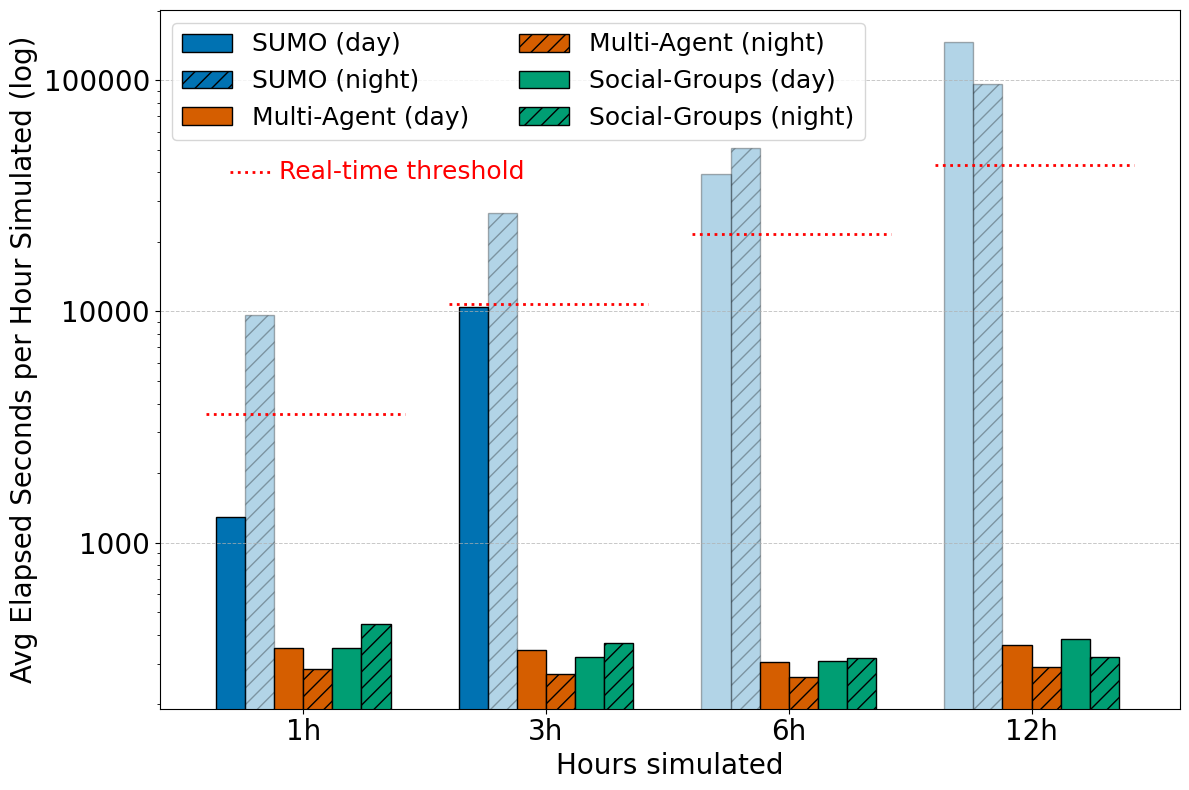

In [18]:
df_social = df_results[df_results["mode"] == 'social_groups_avg']
print(f"Average % agents time over total elapsed time: {df_social['agents_perc_time'].mean() * 100:.2f}%") 
print(f"Average % SUMO time over total elapsed time: {df_social['sumo_perc_time'].mean() * 100:.2f}%") 

# Colors and styles
colors = ['#0072B2', '#D55E00', '#009E73']
x_hours = np.array([1, 3, 6, 12])
x_labels = ['1h', '3h', '6h', '12h']
real_time_threshold = np.array([3600, 10800, 21600, 43200])

# Bar height data for each mode and time of day
bar_data = {
    'SUMO (day)': sumo_avg_d,
    'SUMO (night)': sumo_avg_n,
    'Multi-Agent (day)': ma_avg_d,
    'Multi-Agent (night)': ma_avg_n,
    'Social-Groups (day)': sg_avg_d,
    'Social-Groups (night)': sg_avg_n
}

labels = list(bar_data.keys())
n_groups = len(x_hours)
n_bars = len(bar_data)
bar_width = 0.12
index = np.arange(n_groups)

plt.figure(figsize=(12, 8))

# Plot bars individually with alpha based on threshold
for i, (label, values) in enumerate(bar_data.items()):
    hatch_style = '' if 'day' in label else '//'
    color = colors[i // 2]
    for j in range(n_groups):
        x_pos = index[j] + i * bar_width
        alpha_val = 0.3 if values[j] > real_time_threshold[j] else 1.0
        plt.bar(x_pos, values[j], bar_width,
                label=label if j == 0 else None,
                color=color, edgecolor='black',
                hatch=hatch_style, alpha=alpha_val)

# Plot real-time threshold lines (horizontal, dashed)
for i in range(n_groups):
    plt.hlines(real_time_threshold[i],
               xmin=index[i] - 0.1,
               xmax=index[i] + bar_width * n_bars,
               colors='red', linestyles=':', linewidth=2)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0f}'.format(y) if y > 0 else '0'))

# Axes styling
plt.xticks(index + bar_width * (n_bars - 1) / 2, x_labels, fontsize=20)
plt.yticks([1, 10, 100, 1000, 10000, 100000], fontsize=20)
plt.xlabel('Hours simulated', fontsize=20)
plt.ylabel('Avg Elapsed Seconds per Hour Simulated (log)', fontsize=20)
plt.plot([0, 0.18], [40000, 40000], color='red', linestyle=':', linewidth=2)
plt.text(0.2, 40000, 'Real-time threshold', fontsize=18, verticalalignment='center', color='red')
leg = plt.legend(fontsize=18, loc='upper left', ncol=2)
for h in leg.get_patches():
    h.set_alpha(1.0)
plt.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.savefig("results/responsiveness.png", dpi=300, bbox_inches='tight')
plt.show()